# Analysis for GPT paper

This notebook analyses a dataset of Arxiv papers for our paper Deep learning, deep change? Mapping the development of the Artificial Intelligence General Purpose Technology

**Activities**

1. Load the data:
 * Paper metadata
 * Paper topic mix
 * CrunchBase metadata
 * Other metadata for geocoding
2. Analysis
  2. Descriptive analysis of DL as a GPT
     * Rapid improvement: Has there been a rapid increase in the number of DL papers?
     * Rapid diffusion in other areas: Has there been an adoption of DL in a wide number of areas?
     * Innovation in other areas: Have the DL papers been influential where they have been adopted (i.e. do they receive more citations than other papers in their category?
  3. Geographical aspects of a GPT
    * Do we see shifts in the geography of activity followed by changes in concentration?
    * We perform this analys at the international and regional level
  4. Drivers of the geography of DL
    * Model of DL research specialization based on research and industry co-location
    * Comparison with other `arXiv` subjects


## 0. Preamble

In [4]:
from __future__ import unicode_literals

%matplotlib inline

#Some imports
import matplotlib.patches as mpatches

#Geocoding
import geopandas as gp
from shapely.geometry import Point

from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import zscore

import random

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


### Functions and classes

In [74]:
# Basic functions

#Flatten list

def flatten_list(a_list):
    '''
    Utility function that takes a list of nested elements and flattens it
    
    '''
    
    return([x for el in a_list for x in el])

def flatten_freqs(a_list):
    '''
    Utility function that flattens a list and returns element frequencies
    
    '''
    
    #This flattens the list and returns value counts
    return(pd.Series(flatten_list(a_list)).value_counts())


#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)

# Paper classification

class DlPaperClassification():
    '''
    The class takes a paper df, a topic mix and an index for the topics which contain DL.

    It has a .label_papers method that takes the topic mix and categories papers into DL groups.
    
    It also generates a categorical variable indicating if a paper is 'specialist' (dl is top category) or 
    embedded (dl is simply present)
        
    '''
    
    def __init__(self,papers,topic_mix,dl_var):
        '''
        Initialise the class with a papers file,
        A topic mix file and a list of DL categories.
        
        '''
        
        #NB we will have 
        self.papers = papers
        self.topics = topic_mix
        
        #This can be more than one
        self.dl_var = dl_var
        
        
    def label_papers(self,thres=0.2):
        '''
        We label papers into different levels of DL activity based on the weight
        in their topic mix
        -present if it is above a certain threshold
        -top if it is the top topic (not necessarily above 0.5)
        
        '''
        
        #Load all the information we need for the analysis
        papers = self.papers
        topics = self.topics
        dl_var = self.dl_var
        
        #Classify papers into categories
        #Is the DL topic present?
        dl_present = pd.Series(topics[dl_var].apply(lambda x: x>thres),
                              name='dl_present')
        
        #Is the DL topic the biggest one?
        dl_max = pd.Series(topics.idxmax(axis=1)==dl_var,name='dl_spec')
                
        #Concatenate all categories and index them (to concatenate with the papers in a moment)
        dl_all_class = pd.concat([dl_present,dl_max],axis=1)
        
        #We define an 'embed' category if papers have dl presence but are not specialised
        dl_all_class['dl_embed'] = (dl_all_class['dl_present']==True) & (dl_all_class['dl_spec']==False)
        
        dl_all_class.index = topics.index
        
        #Concatenate papers and our topic classification
        papers_lab = pd.concat([papers,dl_all_class],axis=1)
        
        #And give them a categorical variable depending on whether they are specialist or embedded
        papers_lab['dl_category'] = ['dl_spec' if x==True else 'dl_embed' if y==True else 'not_dl' for
                                      x,y in zip(papers_lab['dl_spec'],papers_lab['dl_embed'])]
    
        #Save outputs
        #Labels stores the labels we have created
        self.labels = dl_all_class
        
        #Papers_lab stores the paper metadata labelled
        self.papers_lab = papers_lab
        
        #topics_agg stores the aggregated topics (mostly for checking)
        #self.topics_agg = topic_aggregated     
        
        return(self)

def sense_checker(data,text_var,sample_size=10,text_size=300):
    '''
    This function takes a dataset, draws random samples from it and prints the text so we can sense-check the quality of the matches.
    
    '''
    
    #Draw a random sample of size sample size from the data
    drawn = random.sample(list(data.index),sample_size)
    
    #return(data.loc[drawn])
    
    
    #For each element we have drawn from the sample we print the text variable up to the parameter length
    for obs in data.loc[drawn][text_var]:
        print(obs[:text_size])
        print('\n')


def get_descriptives(df):
    '''
    Function to get descriptive statistics
    
    ----------
    Parameters
    ----------
    df
    
    ---------
    Returns
    ----------
    -Average number of authors, average year, average number of fields, average number of institutions, average number of citations,
    average number of citations per year
    
    
    '''    
    
    total = len(df)
    years = df['year'].mean()
    fields = df['arxiv_categories'].apply(lambda x: len(x)).mean()
    institutes = df['institutes'].apply(lambda x: len(set(x))).mean()
    #authors = df['institutes'].apply(lambda x: len(x)).mean()
    citations = df['citations'].mean()
    citations_p_year = df[['citations','year']].apply(lambda x: x['citations']/(2019-x['year']),axis=1).mean()
    
    
    out = pd.DataFrame([[total,years,fields,institutes,citations,citations_p_year]],
                      columns=['total','year_average','field_average','institute_average','citation_average','citation_p_year_average']
                      ).apply(lambda x: np.round(x,3))
    
    return(out)
    
    
#GPT analysis

def get_cited_papers(data,citation_var,q=0.75):
    '''
    This function subsets a dataset returning the most cited papers of the period (based on the citation variable and the quantile)
    
    '''
    #Get the quantile
    citation_quantile = papers[citation_var].quantile(q)
    
    #Subset the data
    subset_data = data.loc[data[citation_var]>=citation_quantile]

    return(subset_data)

    
class DlPaperAnalysis_GPT():
    '''
    This class generates descriptive analyses informing our first research question: Is DL a GPT.
    
    It does so with three methods:
    
        .is_growing produces a timeseries comparing levels of activity in DL papers versus the total
        .is_spreading estimates the diffusion of DL papers in different fields
        .is_impactful estimates the citation rates for papers in different fields
    
    '''
    
    def __init__(self,papers,dl_ids):
        ''''
        This function is initialised with the full set of papers and the ids of DL papers
        
        '''
        
        #We label the data with the ids
        papers['is_dl'] = ['dl' if x in dl_ids else 'not_dl' for x in papers.index]
        
        #Store the information
        self.papers = papers
        
        #Also store the DL ids although I doubt we will do much with them
        self.dl_ids = dl_ids
        
        #Extract categories (we are only interested in computer science or statistics / ML)
        categories = [x for x in set(flatten_list(papers.arxiv_categories)) if (x[:2]=='cs') | (x=='stat.ML')]
        self.categories=categories
        
    def is_growing(self,
                   #ax,
                   year_lims=(2000,2018),thres_year=2012,high_cited=False):
        '''
        This method charts levels of activity in DL and compares the importance of DL before / after a threshold year
        
        We also give it: 
            -year_lims to subset the x axis
            -thres_year to compare the importance of DL before/after the threshold year
            -high_cited subsets the data to focus on the most highly cited papers each year (its value represents the
            position in the distribution)
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we are focusing on highly cited papers
        if high_cited!=False:
            
            #This loops over years and extracts the top cited papers
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
            
        
        #######################
        #1. Create a timeseries
        #######################
        
        #Create timeseries (note we are subsetting this table with the year lims)
        papers_year = pd.crosstab(papers['year'],papers['is_dl']).loc[year_lims[0]:year_lims[1]]
        
        #Plot
        #papers_year.plot.bar(stacked=True,ax=ax)
    
        #Add titles etc
        
        #if high_cited==False:
         #   title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1}'.format(y0=str(year_lims[0]),y1=str(year_lims[1]))
        #else:
        #    title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1} (top {q} citations in year)'.format(y0=str(year_lims[0]),y1=str(year_lims[1]),
        #                                                                                                      q=str(100*high_cited)+'%')
        
        #ax.set_title(title,size=14)
        
        #Store information
        self.papers_year = papers_year
        
        #############################
        #2. Before / after comparison
        ###############################
        
        #Crosstabs a boolean indicating if the year is before / after the threshold and normalise over the rows
        ct = pd.crosstab(papers['year']>thres_year,papers['is_dl'],normalize=0)
        
        #We want to relabel the index of the crosstab to make the output more readable
        y = str(thres_year)
        
        ct.index=['Before '+y, 'After '+y]
        
        self.dl_shares_change= ct
        
    def is_spreading(self,
                     #ax,
                     year_lims=(2000,2017),thres_year=2012,high_cited=False,pop_categories=False):
        '''
        
        This method charts the diffusion of DL across domains. 
        One annoying aspect of this is that the papers have multiple categories with no weights. 
        We will expand the data and consider categories separately.
        
        pop_categories allows us to focus on the more popular categories of activity where we expect our share estimates to be more robust.
        
        
        #What are the key outputs:
        
        #Line chart representing DL papers as a share of total in papers with different categories
        #Line chart comparing DL papers as a share of total in different categories before / after threshold.
        
        #Note that the ax argument has two elements for the two figures we are drawing.
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we have decided to focus on highly cited papers
        if high_cited!=False:
            #This loops over years and extracts the top cited papers (should probably turn this into a function)
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.arxiv_categories)[self.categories][:pop_categories].index
            
            
        #######
        #1. Create linechart of activity by category
        ########
        
        #We create a couple of containers to store the data
        #Share container stores the share of DL in total (we will use this for plotting)
        cat_share_container =[]
        
        #Cat total container stores the totals for each category. We use a dict for this
        cat_total_container = {}
        
        
        #We loop over each category of interest
        for cat in categories:
            #Subset the data to identify papers with the category
            subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]
            
            #We crosstab year vs dl categorical
            subset_year = pd.crosstab(subset['year'],subset['is_dl'])
            
            #Store the totals
            cat_total_container[cat] = subset_year
            
            #If there are any DL papers at all
            if 'dl' in subset_year.columns:
                #Calculate the share of DL papers
                subset_year['share'] = subset_year['dl']/subset_year.sum(axis=1)
                
                #We only output the share as a series named after the category (this will become the column name when we concatenate latewr)
                out = pd.Series(subset_year['share'],name=cat)
                
                #Out it comes
                cat_share_container.append(out)
            
        #Create the df filling nas and focusing on our threshold years
        category_share_df = pd.concat(cat_share_container,axis=1).fillna(0).loc[year_lims[0]:year_lims[1]]
        
        
        #Now we plot this.
        #Note that we are assuming that there are too many variables for a legend. We will probably create a cleaner version with nicer labels later.
        #category_share_df.rolling(window=3).mean().plot(legend=False,color='mediumblue',alpha=0.7,ax=ax[0])
        
        #ax[0].set_title('DL paper shares by ArXiv categories',size=14)
        #ax[0].set_ylabel('Share of all papers in category /year')
        
        #Store results
        self.cat_totals = cat_total_container
        self.cat_shares = cat_share_container
        self.cat_shares_df = category_share_df
        
        #########
        #2. Create barchart comparing two intervals
        #########

        cat_period_container = []

        #As before, we loop over categories.
        for cat in categories:
                #Subset the data to identify papers with the category
                subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]

                #We crosstab a boolean (before / after threshold) vs the dl boolean
                subset_ct = pd.crosstab(subset['year']>thres_year,subset['is_dl'],normalize=0)
                
                #This is to relabel the index (useful for the chart later)
                y = str(thres_year)
                subset_ct.index=['Before '+y, 'After '+y]
        

                #We append to the container, turning into a series so we can rename
                cat_period_container.append(pd.Series(subset_ct['dl'],name=cat))

        #Create the df
        cat_thres_df = pd.concat(cat_period_container,axis=1).T.sort_values('After '+y,ascending=True)
        
        #cat_thres_df.plot.bar(ax=ax[1])
        
        #ax[1].set_title('Change in DL shares before/after '+str(thres_year),size=14)
        #ax[1].set_ylabel('Share of all papers in category/year')
        
        
        #Store the df
        
        self.cat_thres_df = cat_thres_df
            
        
    def is_impactful(self,
                     #ax,
                     q=0.75,year_thres=2012,pop_categories=False):
        '''
        Finally, we want to check if DL papers are 'impactful' - do they tend to receive more citations than other papers in each field?
        
        To measure this we will estimate, for each category, what is the share of DL papers in total vs share of highly cited Dl papers. 
        
        We focus on papers published from a threshold year to avoid being skewed by changes in the historical distribution of papers.
        
        '''
        
        #Load papers and categories
        papers = self.papers
        categories = self.categories
        
        cit_cont=[]
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.loc[papers.year>year_thres,'arxiv_categories'])[categories][:pop_categories].index
        
        #For each category
        for cat in categories:
            try:
                #Here we have the papers since threshold (eg 2012) in the category
                subset = papers.loc[(papers.year>year_thres) & ([cat in x for x in papers['arxiv_categories']])]

                #Share of dl in all papers
                dl_all = subset['is_dl'].value_counts(normalize=True)['dl']

                #Share of dl in highly cited papers
                #We use a previous function to subset this
                subset_high_cited = get_cited_papers(subset,'citations',q)

                dl_high_cited = subset_high_cited['is_dl'].value_counts(normalize=True)['dl']

                #out = pd.Series([dl_all,dl_high_cited],index=['dl_share_all','dl_share_high_cited'],name=cat)

                #We output an index which normalises the share of high cited papers by the total. 
                #It is positive if DL papers are overrepresented amont the highly cited ones
                out = pd.Series([dl_all,dl_high_cited],index=['all','high_cited'],name=cat)


                cit_cont.append(out)
            except:
                pass
            
        #Create citation df
        citation_df = pd.concat(cit_cont,axis=1).T
        
        #return(cit_cont)
        
        #And plot it
        #citation_df.sort_values('high_cited_total_ratio',ascending=False).plot.bar(ax=ax,legend=False)
        
        #Add title
        #ax.set_title('DL paper citation \'competitiveness\' \n (papers published after {y}, top {q} citations in period))'.format(
        #    y=str(year_thres),q=str(100*q)+'%'))
        
        #And x label
        #ax.set_ylabel('(DL papers share of highly cited/ \n DL papers share of all)-1')
        
        
        #Store the df
        self.citation_impact_df = citation_df
        
        return(self)
    
# GPT figures

def make_fig1_1(df,ax):
    '''
    Makes figure 1 for the paper
    
    '''
    
    df.plot.bar(ax=ax[0])
    (100*df.apply(lambda x: x/x.sum(),axis=1)).plot.bar(stacked=True,ax=ax[1])

    ax[1].get_legend().set_visible(False)

    ax[0].set_ylabel('Papers in arXiv',size=12)
    ax[1].set_ylabel('Papers in arXiv \n  (% of total)',size=12)
    ax[1].set_xlabel('')
    
    
def make_fig_2(df1,df2,ax):
    '''
    
    Makes figure 2 (line chart plus scatter)
    
    '''
    
    
    (100*df1.rolling(3).mean()).plot(ax=ax[0],alpha=0.5,linewidth=2,color='blue')
    
    (100*df2['Before 2012']).plot(markeredgecolor='blue',marker='o',color='powderblue',ax=ax[1],markerfacecolor='blue')
    (100*df2['After 2012']).plot(markeredgecolor='orange',marker='o',color='bisque',ax=ax[1],markerfacecolor='orange')
    
    ax[1].vlines(np.arange(len(df2)),ymin=len(df2)*[0],ymax=100*df2['After 2012'],linestyle=':',)
    
    ax[1].set_xticks(np.arange(len(df2)))
    ax[1].set_xticklabels(df2.index,rotation=90)

    
    ax[0].set_ylabel('DL as % of all papers \n in each category',size=12)
    ax[1].set_ylabel('DL as % of all papers \n in each category',size=12)

    ax[0].legend().set_visible(False)
    ax[1].legend()
    
def make_fig_3(df,ax):
    '''
    
    Scatter
    
    '''
    
    df = 100*df
    
    col = ['orange' if x['high_cited']>x['all'] else 'blue' for _,x in df.iterrows()]
    
    
    

    ax.scatter(df['all'],df['high_cited'],
               c=col,alpha=0.8,edgecolor=col)

    for x in df.index:

        
        al = df.loc[x]['high_cited']/100+0.3

        ax.annotate(s=x,xy=(df.loc[x]['all'],df.loc[x]['high_cited']),size=12,alpha=al)


    ax.plot([0,65],[0,65],linestyle=':',color='black')
    ax.set_ylim(0,65)
    ax.set_xlim(0,65)
    
    ax.set_xlabel('Share of all papers',size=18)
    ax.set_ylabel('Share of all \n highly cited papers',size=18)

#Geo analysis

def geo_dash_data(papers,shape,geo_var,high_cited=0.5,thres=2012,top_locs=20,ranking=10):
    '''
    Returns data for geographical analysis:
    
    -geopandas dfs for a geographical comparison
    -barchart for before/after LQ comparison
    -Yearly LQs by location for boxplot comparison
    -Concentration of activity for concentration comparison
    
    '''
    selected_places = papers.loc[papers['dl_cat']=='dl',:].groupby(geo_var).size().sort_values(ascending=False).index[:top_locs] 
    
    
    #If we want to focus on high cited, apply the high cited function
    if high_cited!=False:
        papers = get_high_cited_year(papers,high_cited,[2007,2018])
        
    papers['thres'] = [f'pre_{thres}' if x<thres else f'post_{thres}' for x in papers['year']]
    
    ###
    #Get specialisation
    ###
    
    y_1 = get_geo_spec(shape,papers.loc[papers['year']<thres,:],geo_var)
    y_2 = get_geo_spec(shape,papers.loc[papers['year']>thres,:],geo_var)
    
    #return([y_1,y_2])
    
    ###
    #Get changes
    ###
    pre_after = papers.groupby('thres').apply(lambda x: create_lq_df(pd.pivot_table(
        x.groupby([geo_var,'dl_cat']).size().reset_index(drop=False).fillna(0),index=geo_var,columns='dl_cat',values=0))['dl'])
    
    comp = pd.pivot_table(pre_after.reset_index(drop=False),index=geo_var,columns='thres',values='dl').fillna(0).loc[selected_places]
    
 
    #return(comp)
    
    ###
    #Get volatility
    ###
    
    year_lqs = pd.pivot_table(papers.loc[papers.year>2008].groupby(['year']).apply(lambda x: create_lq_df(pd.pivot_table(
        x.groupby([geo_var,'dl_cat']).size().reset_index(drop=False).fillna(0),index=geo_var,columns='dl_cat',
        values=0))['dl']).reset_index(drop=False).fillna(0),index=geo_var,columns='year',values='dl').fillna(0)
    
    #return(year_lqs)
    
    ###
    #Get concentration 
    ###
    
    conc_dl = papers.loc[(papers.dl_cat=='dl')&(
        papers.year>2008),:].groupby('year').apply(lambda x: get_concentration(x.groupby(geo_var).size(),ranking))
    
    conc_all = papers.loc[(papers.year>2008),:].groupby('year').apply(lambda x: get_concentration(x.groupby(geo_var).size(),ranking))

    
    return([
        [y_1,y_2],
        comp,
        year_lqs,
        [conc_dl,conc_all]])

def get_geo_spec(shape,df,geo_var):
    '''
    Calculates specialisation by geography
    
    '''
    #We merge the shapefile with LQS by shapefile
    spec = pd.merge(shape,create_lq_df(pd.pivot_table(df.groupby([geo_var,'dl_cat']).size().reset_index(drop=False),
                   index=geo_var,columns='dl_cat',values=0).fillna(0)),left_on=geo_var,right_on=geo_var,how='left').fillna(0)
    
    spec_tots = pd.pivot_table(df.groupby([geo_var,'dl_cat']).size().reset_index(drop=False),
                   index=geo_var,columns='dl_cat',values=0).fillna(0)
    spec_tots.columns = [x+'_total' for x in spec_tots.columns]
    
    spec = spec.set_index(geo_var).join(spec_tots).fillna(0)
    
    return(spec)

def get_concentration(vector,top):
    '''
    Gets the % of activity accounted by the top x organisations
    
    
    '''
    
    share_captured = vector.sort_values(ascending=False)[:top].sum()/vector.sum()
    
    return(share_captured)

def make_map(df,variable,variable_totals,ax,cmap,shade_low=True,edge=0.5,q=0.9):
    '''
    This makes a map.
    We add an alpha depending on position in the decile of activity
 
    
    '''
    
    #df['alpha'] = pd.qcut(df[variable_totals],q=np.arange(0,1.1,0.1),duplicates='drop',labels=False)/10
    df[variable] = [lq if tot>df[variable_totals].quantile(q) else 0 for lq,tot in zip(df[variable],df[variable_totals])]
    
    
    #print(df[variable_totals].quantile(0.75))
    
    df.plot('dl',ax=ax,
            scheme='fisher_jenks',
            colormap=cmap,edgecolor='darkgrey',linewidth=edge,
            legend=True
           )

    ax.get_legend().set_bbox_to_anchor((0.19,0.5))
    ax.get_legend().set_title('Location quotient')
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

def make_geo_bar(df,ax):
    
    df.index = [x if 'South West' not in x else 'SWCDC (Singapore)' for x in df.index ]
    
    df['pre_2012'].plot(markeredgecolor='blue',marker='o',color='white',ax=ax,markerfacecolor='blue')
    df['post_2012'].plot(markeredgecolor='orange',marker='o',color='white',ax=ax,markerfacecolor='orange')
    

    col = ['orange' if x>y else 'blue' for x,y in zip(df['post_2012'],df['pre_2012'])]
    
    ax.vlines(np.arange(len(df)),ymin=df['pre_2012'],ymax=df['post_2012'],linestyle=':',color=col)
    ax.hlines(y=1,xmin=0,xmax=len(df),color='darkgrey',linestyle='--')
    
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels(df.index,rotation=90)

    ax.legend()
    ax.set_ylabel('Relative comparative advantage')
    #ax[1].set_ylabel('DL as % of all papers in each category')
    ax.set_xlabel('')
    
    
def volatility_concentration(df_vol,df_conc,ax,selected_locations,ylim=[50,70]):
    '''
    Volatility and concentration plots
    
    '''
    
    #df_vol.loc[selected_locations].boxplot(ax=ax[0],grid=False)
    
    v = ax[0].violinplot([df_vol.loc[selected_locations,col] for col in 
                df_vol.columns],
              showextrema=True,
              showmeans=True)
    
    for pc in v['bodies']:
        pc.set_facecolor('orange')
        pc.set_edgecolor('lightblue')
        pc.set_alpha(0.7)

    ax[0].set_xticks(np.arange(len(df_vol.columns))+1)
    ax[0].set_xticklabels(df_vol.columns)
    
    (100*pd.concat(df_conc,axis=1)).plot(ax=ax[1])
    
    ax[1].legend(['Deep Learning','All'])
    
    ax[1].set_ylim(ylim[0],ylim[1])

def get_high_cited_year(data,q,year_lims):
    '''
    This function extracts high cited papers by year (to control for citation times).
    TODO - put this function in all classes above
    
    '''
    #This loops over the years and extracts papers in the top quantile of activity.
    
    out = pd.concat([get_cited_papers(data.loc[data.year==x,:],'citations',
                                      q) for x in np.arange(year_lims[0],year_lims[1])])
    
    return(out)

def calculate_herfindahl(series):
    '''
    This function takes a series and returns its herfindahl index (the sum squared of the share of each observation in the total)
    
    '''
    
    herf = np.sum([(x/np.sum(series))**2 for x in series])
    return(herf)

def sort_shares_for_concentration_plot(df,cols):
    '''
    This function takes a df with shares of activity by area and returns a df ready for plotting to analyse concentration
    focusing on the columns of interest
    
    '''
    
    totals_sorted = pd.concat([
            df.sort_values(col,ascending=False)[col].reset_index(drop=True) for col in cols],axis=1)
        
    shares_sorted = totals_sorted.apply(lambda x: x/x.sum()).cumsum()
        
    return(shares_sorted)

def concentration_analysis(papers_df,level):
    '''
    This function takes a papers df and a level of analysis performs a concentration analysis which returns
    a herfindahl index which returns a concentration index for the level of activity, and a df with cumulative shares
    of activity to visualise in a plot.
    
    '''
    
    #Calculate totals by category (DL and not DL)
    totals_by_cat = pd.pivot_table(papers_df.groupby([level,'is_dl']).size().reset_index(),
                                   index=level,columns='is_dl',values=0).fillna(0)
        
    #And categories for the totals
    totals_by_cat['total'] = totals_by_cat.sum(axis=1)
        
    #Calculate Herfindahl with a function we defined before. We are only interested in DL and the total benchmark
    herf = totals_by_cat.apply(lambda x: calculate_herfindahl(x))[['dl','total']]
        
    #Store the herfindahl indices
    
        
    #To visualise these columns we creata
        
    shares_sorted = sort_shares_for_concentration_plot(totals_by_cat,['dl','total'])
    
    return([herf,shares_sorted])

#Similarities and specialisations

def get_category_spec(df,geo_var,cat_var,sel,norm=False):
    """
    
    Steps: activity matrix -> normalise
    
    Takes df, location, whether we want location quotients or totals, and the sector variables to select
    
    """
    
    paper_act = pd.pivot_table(df.groupby(geo_var)[cat_var].apply(lambda x: flatten_freqs(x)).reset_index(drop=False),
                               index=geo_var,columns='level_1',values=cat_var).fillna(0)[sel]
    
    if norm==True:
        return(create_lq_df(paper_act))
    else:
        return(paper_act)

    
def get_local_similarity(act,sim,rel_var,symmetrical=True):
    '''
    
    Multiplies the activity by distance and extract
    
    '''
    #Multiplies by the weights, removes itself and adds
    
    if symmetrical==True:
        weighted_act = act.apply(lambda x: x*sim[rel_var],axis=1).drop(rel_var,axis=1).sum(axis=1)
    else:
        weighted_act = act.apply(lambda x: x*sim[rel_var],axis=1).sum(axis=1)
    
    return(weighted_act)

# Modelling

def flatten_list(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])


def dummies_from_list(list_of_categories):
    '''
    This function takes a list of categories and returns a df where every column is a dummie for each unique variable
    in the category. Admittedly, the function could be nicer.
    
    '''

    #We concatenate a bunch of series whose indices are the names of the variables.
    #We could have done something similar by creating DFs with one row
    
    cats = [x for x in set(flatten_list(list_of_categories))]

    df = pd.DataFrame()

    for category in cats:
    
        var = [category in x for x in list_of_categories]

        df[category] = var

    
    
    
    #dummy_df = pd.concat([pd.Series({v:1 for v in obs}) for obs in list_of_categories],axis=1).T.fillna(0)
    return(df)
    
    
#Run models
def data_temp(var,sector_var='cats',year_thres=2012):
    '''
    Prepares the data for a regression with a temporal dimension
    
    '''
    df = papers_modelling.copy()
    
    #Calculate specialisation
    df[var] = [var in x for x in df[sector_var]]
    
    #Target
    act_1 = create_lq_df(pd.pivot_table(df.loc[df.year>year_thres,:].groupby(['name_en',var]).size().reset_index(drop=False),
               index='name_en',columns=var,values=0).fillna(0))[True]
    
    #Controls
    act_0 = create_lq_df(pd.pivot_table(df.loc[df.year<=year_thres,:].groupby(['name_en',var]).size().reset_index(drop=False),
               index='name_en',columns=var,values=0).fillna(0))[True]
    
    #arxiv
    #specialised
    arxiv_act = get_category_spec(papers_admin_map.loc[papers_admin_map.year<=year_thres,:],'name_en','expanded_cats',norm=True,sel=comp_cats+['dl'])
    arxiv_act_sp = get_local_similarity(arxiv_act,sim,'dl',symmetrical=True)
    
    #Total
    arxiv_totals = np.log(papers_admin_map.loc[papers_admin_map.year<=year_thres,:].groupby('name_en').size()+0.01)
    
    #crunchbase
    #specialised
    cb_act = get_category_spec(cb.loc[cb.year<year_thres,:],'name_en','category_split_list',norm=True,sel=sel)
    cb_act_sp= get_local_similarity(cb_act,arx_prox_df,'dl',symmetrical=False)
    
    #Total
    cb_totals = np.log(cb.loc[cb.year<year_thres,:].groupby('name_en').size()+0.01)
    
    #Combine
    all_data = pd.concat([act_1,act_0,
                          arxiv_act_sp,cb_act_sp,
                          arxiv_totals,cb_totals],axis=1,sort=False).fillna(0)
    
    all_data.columns = [var+'_t1',var+'_t0','arx_sp','cb_sp','arx_tot','cb_tot']
    
    all_data['sp_int'] =all_data['arx_sp']*all_data['cb_sp']
    all_data['abs_int'] =all_data['arx_tot']*all_data['cb_tot']

    #all_data = all_data.loc[top_locs]
    #all_data = all_data.apply(lambda x: zscore(x))


    return(all_data)


def model_temp(data,var,top_locs=False,fit_model=True,
               exog_vars=['const',
                          'arx_sp',
                          'cb_sp',
                          'sp_int',
                          'cb_tot',
                          'arx_tot',
                          'abs_int',
                          'is_china']):
    '''
    Cross-sectional regression
    top_locs filters locations by their quartile. 0 means using all
    
    '''
    
    d = data.copy()
    
    if fit_model==False:
        return(d)
    
    else:
        if top_locs!=False:
        #Focus on top arxiv areas?
            top_q_regions = papers_admin_map.groupby(['name_en']).size().quantile(top_locs)


            top_locs = papers_modelling.groupby(['name_en']).size().index[papers_modelling.groupby(['name_en']).size()>top_q_regions]

            d = d.loc[top_locs]
            
            d = d.apply(lambda x: zscore(x))
            
            d['const']=1

            d['country'] = [country_reg_lookup[x] for x in d.index]

            d['is_china'] = [1 if x=='CN' else 0 for x in d['country']]
    
            
            
        ex = exog_vars + [var+'_t0']
        #print(ex)
        
        ols = sm.OLS(endog=d[var+'_t1'],
                     exog=d[ex]).fit(
            #cov_type='cluster',cov_kwds={'groups':d['country']}
        )

        return([ols,d])
    
#Regression table

def create_reg_table(mod):
    '''
    Creates series with coefficients, significance and standard errors
    '''
    
    coef = mod.params
    
    for var in coef.index:
        
        st=  str(np.round(mod.bse[var],3))
        
        #print(mod.pvalues[var])
        if mod.pvalues[var] < 0.01:
            #coef[var] = str(np.round(coef[var],3))+'***' + f'({st})'
            coef[var] = str(np.round(coef[var],3))+'***'
            coef[var+'_se'] = f'({st})'
            
            
        elif mod.pvalues[var] < 0.05:
            
            #coef[var] = str(np.round(coef[var],3))+'***' + f'({st})'
            coef[var] = str(np.round(coef[var],3))+'**'
            coef[var+'_se'] = f'({st})'
            
        elif mod.pvalues[var] < 0.1:
            #coef[var] = str(np.round(coef[var],3))+'*' + f'({st})'
            #coef[var] = str(np.round(coef[var],3))+'***' + f'({st})'
            coef[var] = str(np.round(coef[var],3))+'*'
            coef[var+'_se'] = f'({st})'
            
        else:
            coef[var] = str(np.round(coef[var],3))
            coef[var+'_se'] = f'({st})'
    
    coef['y']='RCA_t1'
    coef['R^2'] = np.round(mod.rsquared_adj,3)
    coef['n'] = mod.nobs
    
    #coef.index = ['$'+x+'$' for x in coef.index]
    
    return(coef)

#Model comparisons
        
def reg_comp_plot(ax,temp=True,top_cats=10,**kwargs):
    '''
    
    Compares model outputs for different arXiv categories
    '''
    
    #print(kwargs)
    
    #Top categories
    top_arxiv_cats = ['dl']+[x for x in list(flatten_freqs(papers_meta.arxiv_categories).index) if any(x.split('.')[0]==y for y in ['cs','stat'])][:top_cats]
    
    #print(kwargs)
    
    #Model outputs
    if temp==True:
        data = data_temp
        mod = model_temp
    else:
        data = data_cross_sect
        mod = model_cross_sect
    
    model_outputs = []

    for cat in top_arxiv_cats:
        #print(cat)

        d = data(cat,'cats')
        m =  mod(d,cat,top_locs=kwargs['top'],exog_vars=kwargs['exog_vars'])
        out = [m[0].params,m[0].conf_int()]
        model_outputs.append(out)
    
    #Extract coefficients from the model outputs
    model_pars_t = pd.concat([x[0] for x in model_outputs],axis=1,sort=False).loc[kwargs['my_vars']]
    model_pars_t.columns = top_arxiv_cats
    
    my_vars = kwargs['my_vars']
    
    #print(model_pars_t)
    
    #Confidence intervals
    yerrvars_l, yerrvars_h = [pd.concat([x[1][num] for x in model_outputs],axis=1,sort=False) for num in [0,1]]
    yerrvars_l.columns, yerrvars_h.columns = top_arxiv_cats,top_arxiv_cats

    yerrvars = [[yerrvars_l.loc[v],yerrvars_h.loc[v]] for v in [my_vars]]
    
    #print(yerrvars)
    
     
    x_n = np.arange(len(my_vars))

    cols= plt.get_cmap('Accent').colors[:5]

    patches = [mpatches.Patch(facecolor=c, label=l,ec='black') for c,l in zip(cols,my_vars)]
    
    for num,x in enumerate(top_arxiv_cats):
        ax.bar([num+0.23*n for n in np.arange(0,len(my_vars))],height=model_pars_t.loc[my_vars,x],width=0.18,color=cols,
               alpha=0.7,edgecolor='black',
               yerr = np.array(yerrvars_l.loc[my_vars,x],yerrvars_h.loc[my_vars,x]), 
               align='center', 
               capsize=3
              )
        ax.vlines(x=num-0.15,ymin=-2.5,ymax=2.5,edgecolor='darkgrey',linestyle='--')



    ax.set_xticks([x+0.21*2 for x in np.arange(len(top_arxiv_cats))])
    ax.set_xticklabels(top_arxiv_cats,rotation=90,size=16)
    ax.legend(handles=patches,loc='upper right',title='Category',fontsize=16,edgecolor='grey',facecolor='white',
              ncol=len(my_vars)
             )

   


## 1. Load data

Download the papers from [here](https://s3.eu-west-2.amazonaws.com/nesta-open-data/arxiv_ai/corex_matched_noOAG.json).

In [6]:
# Load the papers



papers = pd.read_json(
    ',orient='records')

papers.shape

(247931, 60)

There are 247,931 papers. This is total number of CS + Stats papers in Arxiv CS papers (see methodology in paper for a description of the process used for this)

## 2. Initial exploration

In [7]:
#Note that there are many duplicated papers. This seems to be linked to the way they have been geocoded
len(set(papers.arxiv_id))

131189

In [8]:
#Check the data
papers.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,full_title,grid_lat,grid_lon,institutes,journal,language,match_score,match_value,matched,title
0,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.318119],[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions
1,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.389002],[-72.526712],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,University of Massachusetts Amherst,True,sparsity certifying graph decompositions
2,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
3,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
4,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,Sparsely spread CDMA—a statistical mechanics-b...,[52.486],[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...


The data is a timestamp so we parse it, and extract the year

In [9]:
papers['date_parsed'] = [datetime.datetime.fromtimestamp(x/1000) for x in papers['date']]

papers['year'] = papers['date_parsed'].apply(lambda x: x.year)

### CrunchBase analysis

We load a df with total levels of dl activity by sector before 2012, and the proximity DF we will use to calculate similarites.

We cannot make the raw CB data available for licensing reasons.


In [10]:
import ast 

cb = pd.read_csv(proc_data+'/cb_processed.csv')

cb['category_split_list'] = [ast.literal_eval(x) for x in cb.category_split_list]

## 3. Processing

We want to make the data easier to work with.

We will create a df with the topics and an index with the `arxiv_id` and another with other variables we are interested in.

Before doing that we need to deduplicate the papers. The analysis we are doing right now focuses on the diffusion of ML in other topics, for which we don't need individual institution information.

In [11]:
#papers_un means papers unique
papers_un = papers.drop_duplicates('arxiv_id')

papers_un.shape

(131189, 62)

In [12]:
#Create a topic df only including those variables referring to a topic
topics = papers_un.set_index('arxiv_id')[[x for x in papers_un.columns if 'TOPIC' in x]]

topics.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,TOPIC_prove_class_game_general_player_also_hold_existence_theoretic_exists,TOPIC_real_real world_world_widely_widely used_wide_wide range_application_synthetic_commonly used,TOPIC_research_year_ha_recent_human_community_attention_recent year_challenge_become,TOPIC_service_security_mobile_device_traffic_technology_resource_attack_internet_management,TOPIC_simulation_system_simulation result_control_energy_design_controller_simulation result show_sensor_efficiency,TOPIC_social_social network_role_play_robot_dynamic_interaction_decision making_decision_autonomous,TOPIC_software_development_implementation_tool_program_open source_interface_science_programming_execution,TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural,TOPIC_user_account_insight_impact_analysis_provide_study_focus_issue_take account,TOPIC_web_future_social medium_medium_project_business_twitter_organization_review_content
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,0.058000,0.0,0.135712,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
oai:arXiv.org:0704.0047,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,0.028615,0.0,0.000000,0.0,0.016941,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0050,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.049272,0.0,0.000000,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0098,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.079938,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0217,0.026281,0.015733,0.0,0.032564,0.472709,0.000000,0.000000,0.021966,0.000000,0.0,...,0.020230,0.0,0.000000,0.0,0.095396,0.0,0.0,0.0,0.000000,0.0


In [13]:
#These are the topics. The neural network topic are 13 and 36.
for num,x in enumerate(topics.columns):
    print(str(num)+' '+x)

0 TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence
1 TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach
2 TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core
3 TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known
4 TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit
5 TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data
6 TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way
7 TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample
8 TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem
9 TOPIC_experiment_e

The DL topics are 13 and 36



In [14]:
topics.columns[[13,36]]

Index(['TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm', 'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural'], dtype='object')

In [15]:
#And now we create a paper metadata df.
# Note that we have to set the index after subsetting (otherwise the subsetting can't find the arxiv id in the columns!)
papers_meta = papers_un[[x for x in papers_un.columns if 'TOPIC' not in x]].set_index('arxiv_id')

papers_meta.head()

,arxiv_categories,arxiv_created,arxiv_raw_summary,arxiv_raw_title,arxiv_sources,arxiv_summary,arxiv_title,citations,date,doi,...,grid_lon,institutes,journal,language,match_score,match_value,matched,title,date_parsed,year
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]",1175212800000,"We describe a new algorithm, the $(k,\ell)$-pe...",Sparsity-certifying Graph Decompositions,[https://arxiv.org/abs/0704.0002],"[describe, new, algorithm, k, ell, pebble, gam...","[sparsity, certifying, graph, decomposition]",17,1241136000000,10.1007/s00373-008-0834-4,...,[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions,2009-05-01 01:00:00,2009
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",1175385600000,The intelligent acoustic emission locator is d...,Intelligent location of simultaneously active ...,[https://arxiv.org/abs/0704.0047],"[intelligent, acoustic, emission, locator, des...","[intelligent, location, simultaneously, active...",8,1044057600000,10.1108/00022660310457248,...,[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2003-02-01 00:00:00,2003
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",1175385600000,Part I describes an intelligent acoustic emiss...,Intelligent location of simultaneously active ...,[],"[part, describes, intelligent, acoustic, emiss...","[intelligent, location, simultaneously, active...",0,1167609600000,None,...,[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2007-01-01 00:00:00,2007
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]",1175385600000,"Sparse Code Division Multiple Access (CDMA), a...",Sparsely-spread CDMA - a statistical mechanics...,[https://arxiv.org/abs/0704.0098],"[sparse, code, division, multiple, access, cdm...","[sparsely, spread, cdma, statistical, mechanic...",24,1192147200000,10.1088/1751-8113/40/41/004,...,[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...,2007-10-12 01:00:00,2007
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",1175472000000,Given a multiple-input multiple-output (MIMO) ...,Capacity of a Multiple-Antenna Fading Channel ...,[https://arxiv.org/abs/0704.0217?context=cs],"[given, multiple, input, multiple, output, mim...","[capacity, multiple, antenna, fading, channel,...",154,1235865600000,10.1109/TIT.2008.2011437,...,"[-87.673945, None]",[northwestern university],IEEE Transactions on Information Theory,en,1.0,Northwestern University,True,capacity of a multiple antenna fading channel ...,2009-03-01 00:00:00,2009


In [16]:
#Select columns of interest
my_columns = ['arxiv_categories','arxiv_raw_summary','arxiv_title', 'citations','year','full_title','journal','institutes']

#These columns are picking up the description of the papers, the institutes involved, the journal and the year.
#I need all these things for the analysis of 'diffusion' which is coming up.

papers_meta = papers_meta[my_columns]

papers_meta.head()

,arxiv_categories,arxiv_raw_summary,arxiv_title,citations,year,full_title,journal,institutes
arxiv_id,,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-pe...","[sparsity, certifying, graph, decomposition]",17,2009,Sparsity-certifying Graph Decompositions,Graphs and Combinatorics,"[smith college, university of massachusetts am..."
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",The intelligent acoustic emission locator is d...,"[intelligent, location, simultaneously, active...",8,2003,Intelligent location of simultaneously active ...,Aircraft Engineering and Aerospace Technology,[university of ljubljana]
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",Part I describes an intelligent acoustic emiss...,"[intelligent, location, simultaneously, active...",0,2007,Intelligent location of simultaneously active ...,arXiv preprint arXiv:0704.0050,[university of ljubljana]
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]","Sparse Code Division Multiple Access (CDMA), a...","[sparsely, spread, cdma, statistical, mechanic...",24,2007,Sparsely spread CDMA—a statistical mechanics-b...,Journal of Physics A,"[aston university, hong kong university of sci..."
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",Given a multiple-input multiple-output (MIMO) ...,"[capacity, multiple, antenna, fading, channel,...",154,2009,Capacity of a Multiple-Antenna Fading Channel ...,IEEE Transactions on Information Theory,[northwestern university]


## 2. Analysis

### a. Paper classification
Our first stage is a descriptive analysis of DL activity: in order to do this, we need to combine the paper data and the topic mix data and then label papers based on the relative importance of the DL topics. We will then plot some descriptives.

We will start with a class that classifies papers depending on the presence of DL topics. Since we have two topics and it is not straightforward to combine coefficients into a single 'DL weight', we will classify the papers twice and then combine all the information to generate a DL variable.

In [17]:
#Run the analysis for both classes
dl_vars = [
    'TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm',
    'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural']

#Each of the elements in dl classified is the output of the classification for a topic
dl_classified = [DlPaperClassification(papers_meta,topics,var).label_papers(thres=0.5).labels for var in dl_vars]

In [18]:
#We create two lists of dl papers: one that appears in either topic (expansive) and one that appears in both (restrictive)

#Expansive (is in both)
papers_expansive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) | (dl_classified[1]['dl_present']==True)].index

#Restrictive (is only in one)
papers_restrictive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) & (dl_classified[1]['dl_present']==True)].index

print(len(papers_expansive))
print(len(papers_restrictive))

15602
1604


In [19]:
top_0 = dl_classified[0].loc[(dl_classified[0]['dl_present']==True)].index
top_1 = dl_classified[1].loc[(dl_classified[1]['dl_present']==True)].index

In [20]:
print(len(papers_expansive)/len(dl_classified[0]))
print(len(papers_restrictive)/len(dl_classified[0]))

0.11892765399538072
0.012226634855056446


In [21]:
# print('Expansive')
# print('=========')
# sense_checker(papers_meta.loc[papers_expansive],text_var='arxiv_raw_summary')


# print('Restrictive')
# print('=========')
# sense_checker(papers_meta.loc[papers_restrictive],text_var='arxiv_raw_summary')

# print('diff')
# print('=========')
# sense_checker(papers_meta.loc[set(papers_expansive)-set(papers_restrictive)],text_var='arxiv_raw_summary')



In [22]:
papers_meta_desc = papers_meta.copy()

both = set(top_0) & set(top_1)
only_t0 = set(top_0)-set(top_1)
only_t1 = set(top_1)-set(top_0)

papers_meta_desc['dl_cat'] = ['both' if x in both else 't0' if x in only_t0 else
                             't1' if x in only_t1 else 'non_dl' for x in papers_meta_desc.index]


We will focus on the expansive version

### b. Descriptive analysis

### Basic descriptives

In [23]:
# Quick: Number of papers, average year, average number of authors, average number of institutions,
# average number of citations, average number of fields

In [24]:
papers_meta_desc = papers_meta.copy()

papers_meta_desc['dl_cat'] = ['dl' if x in papers_expansive else 'non_dl' for x in papers_meta_desc.index]

In [25]:
descr = papers_meta_desc.groupby('dl_cat').apply(lambda x: get_descriptives(x))

In [26]:
descr

,,total,year_average,field_average,institute_average,citation_average,citation_p_year_average
dl_cat,,,,,,,
dl,0,15602,2015.937,1.798,1.754,25.627,6.182
non_dl,0,115587,2013.572,1.930,1.705,18.003,2.505


In [27]:
comp_cats = [x for x in set(flatten_list(papers_meta_desc['arxiv_categories'])) if x.split('.')[0]=='cs']+['stat.ML']

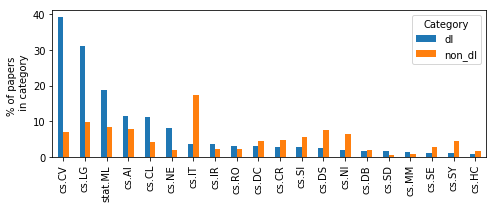

In [28]:
## More descriptive analysis

fig,ax = plt.subplots(figsize=(7,3))


(100*pd.pivot_table(
    papers_meta_desc.groupby('dl_cat')['arxiv_categories'].apply(lambda x: flatten_freqs(x)/len(x)).reset_index(drop=False),
    index='level_1',columns='dl_cat',values='arxiv_categories').loc[comp_cats].sort_values('dl',ascending=False)[:20]).plot.bar(ax=ax)

ax.set_xlabel('')
ax.set_ylabel('% of papers \n in category')
ax.legend().set_title('Category')


plt.tight_layout()

### Geography

#### i. Pre-processing: Bin into countries / regions


Get the Shapefiles here [here](https://www.naturalearthdata.com).

 * [Countries](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/)
 * [Provinces](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/)

In [29]:
#Read the shapefile

admin_shape = gp.read_file(ext_data+'/admin_shapefile/ne_10m_admin_1_states_provinces.shp')
country_shape = gp.read_file('../data/external/ne_10m_admin_0_countries.shp')

admin_shape['country_reg'] = [str(x)+'_'+str(y) for x,y in zip(admin_shape.iso_a2,admin_shape.name_en)]

In [30]:
#We will use a spatial join. To do this we need to create a geopandas df with the spatial coordinates
#for each paper. We will create an individual paper id for each paper-institution pair so it's straightforward to
#merge things later

papers['paper_id'] = ['id_'+str(num)+'_'+str(match) for num,match in enumerate(papers.match_value)]

#We create a geo papers df with the lat lon
geo_paper = papers.set_index('paper_id')[['grid_lat','grid_lon']]

In [31]:
#Some of the papers here have multiple lat lons - they are from institutions with multiple locations.
#We will drop them from now.
geo_paper = geo_paper.loc[[len(x)==1 for x in geo_paper['grid_lat']]]

#Also drop papers with 'none' l
geo_paper = geo_paper.loc[[x[0]!=None for x in geo_paper['grid_lat']]]
geo_paper = geo_paper.dropna(subset=['grid_lat'])

In [32]:
#Now we turn the lat and lon into coordinates
paper_points = geo_paper.apply(lambda x: Point([x['grid_lon'][0],x['grid_lat'][0]]),axis=1)

#And create the geodataframe
papers_geodf = gp.GeoDataFrame(geo_paper,geometry=paper_points)

In [33]:
#Make sure we have the same coordinates
papers_geodf.crs= admin_shape.crs

In [34]:
#And do the spatial join - the operation indicates that we are doing a point in polygon.
papers_geographies = gp.sjoin(papers_geodf,admin_shape,op='within')

#Also with countries
papers_countries = gp.sjoin(papers_geodf,country_shape,op='within')

In [35]:
#Focus on the variables we are interested in (country and region)
papers_geo_short = pd.DataFrame(papers_geographies[['admin','name_en','country_reg']])

#Merge with the papers df
papers_all= papers.set_index('paper_id').join(papers_geo_short,how='left')


In [36]:
#Create the papers df for spatial analysis
#Variables of interest

my_vars = ['arxiv_id','title','arxiv_raw_summary','arxiv_categories',
           'journal','citations','institutes',
    'grid_lat','grid_lon','admin','name_en','country_reg','year']

papers_spat = papers_all[my_vars].dropna(subset=['name_en'])

#Remove all observations with empty geocodes
papers_spat = papers_spat.loc[[len(x)>0 for x in papers_spat['admin']]]

papers_spat['grid_lat'],papers_spat['grid_lon'] = [[x[0] for x in papers_spat[variable]] for variable in ['grid_lat','grid_lon']]


In [37]:
papers_spat.rename(columns={'name_en':'region','admin':'country'},inplace=True)

In [38]:
papers_spat['dl_cat'] = ['dl' if x in papers_expansive else 'non_dl' for x in papers_spat.arxiv_id]

In [39]:
(100*(pd.pivot_table(papers_spat.groupby(['country','dl_cat']).size().reset_index(drop=False),
               index='country',columns='dl_cat',values=0).fillna(
    0).apply(lambda x:x/x.sum(),axis=0))).sort_values('dl',ascending=False)[:20]

dl_cat,dl,non_dl
country,,
United States of America,32.279793,31.083721
China,11.917098,5.008269
United Kingdom,7.543178,6.966408
Germany,5.980138,6.660465
Canada,4.006908,3.879070
France,3.860104,6.280620
Australia,3.851468,2.850646
Italy,2.871330,3.235659
Switzerland,2.642487,1.924548


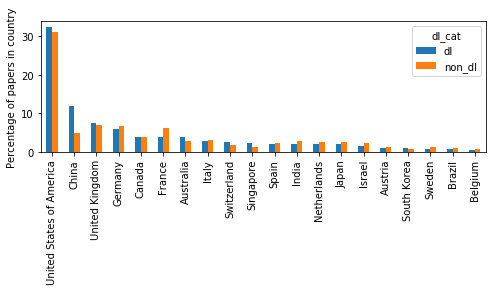

In [40]:
fig,ax = plt.subplots(figsize=(7,4))


(100*(pd.pivot_table(papers_spat.groupby(['country','dl_cat']).size().reset_index(drop=False),
               index='country',columns='dl_cat',values=0).fillna(
    0).apply(lambda x:x/x.sum(),axis=0))).sort_values('dl',ascending=False)[:20].plot.bar(ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Percentage of papers in country')

plt.tight_layout()

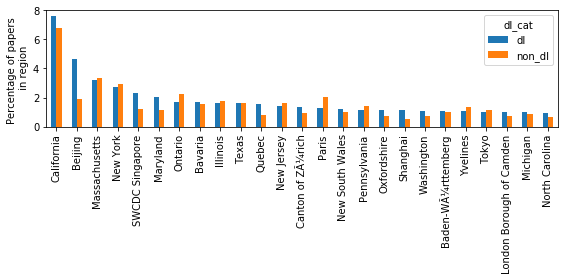

In [41]:
fig,ax = plt.subplots(figsize=(8,4))


(100*pd.pivot_table(papers_spat.groupby(['country_reg','dl_cat']).size().reset_index(drop=False),
               index='country_reg',columns='dl_cat',values=0).fillna(
    0).apply(lambda x:x/x.sum(),axis=0).sort_values('dl',ascending=False)[:25]).plot.bar(ax=ax)

ax.set_xticklabels([x.get_text().split('_')[1] if 'South West' not in x.get_text() else 'SWCDC Singapore' for x in ax.get_xticklabels()])

ax.set_xlabel('')
ax.set_ylabel('Percentage of papers \n in region')

plt.tight_layout()

plt.tight_layout()

### b. Descriptive analysis: GPTs

Having selected a set of papers to work with, we address our descriptive research questions.

We will build a class that addresses these questions through its methods:

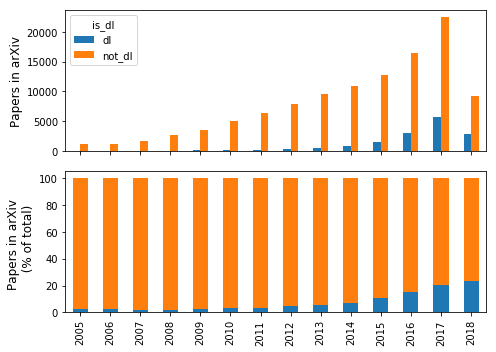

In [42]:
test = DlPaperAnalysis_GPT(papers_meta,papers_expansive)
test.is_growing(year_lims=(2005,2018))


fig,ax = plt.subplots(figsize=(7,5),nrows=2,sharex=True)

make_fig1_1(test.papers_year,ax)

plt.tight_layout()


Fast increase of activity in ArXiv.

DL appears to be growing at a faster rate, consistent with the 'rapidity' thesis

In [43]:
100*test.dl_shares_change

is_dl,dl,not_dl
Before 2012,3.218110,96.781890
After 2012,15.074702,84.925298


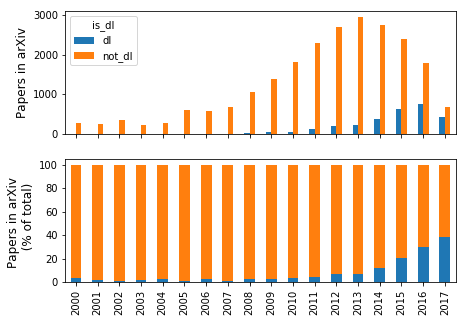

In [44]:
test2 = DlPaperAnalysis_GPT(papers_meta,papers_expansive)

test2.is_growing(high_cited=0.75)

fig,ax = plt.subplots(figsize=(7,5),nrows=2,sharex=True)

make_fig1_1(test2.papers_year,ax)



In [45]:
test.is_spreading(pop_categories=40,year_lims=(2005,2018))

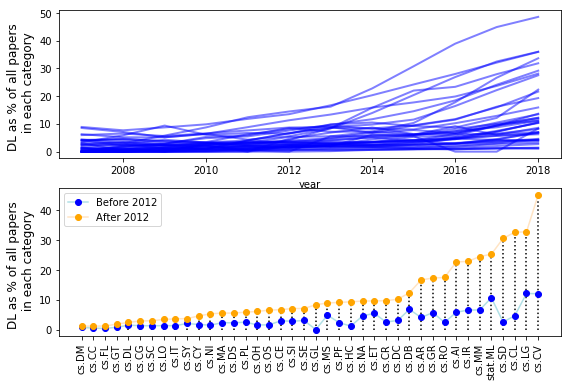

In [46]:
fig,ax = plt.subplots(figsize=(9,6),nrows=2)

make_fig_2(test.cat_shares_df,test.cat_thres_df[['Before 2012','After 2012']],ax)

DL is becoming more important in multiple disciplines. This includes disciplines that specialise in the development of AI technologies (eg `cs.NE` = neural networks, or `cs.AI` = AI) but also others such as Computer Vision, Computation and Language, or Information Retrieval or graphics. 

In [47]:
impact_df = [test.is_impactful(year_thres=y,pop_categories=40,q=0.75).citation_impact_df for y in [2009,2012,2015]]

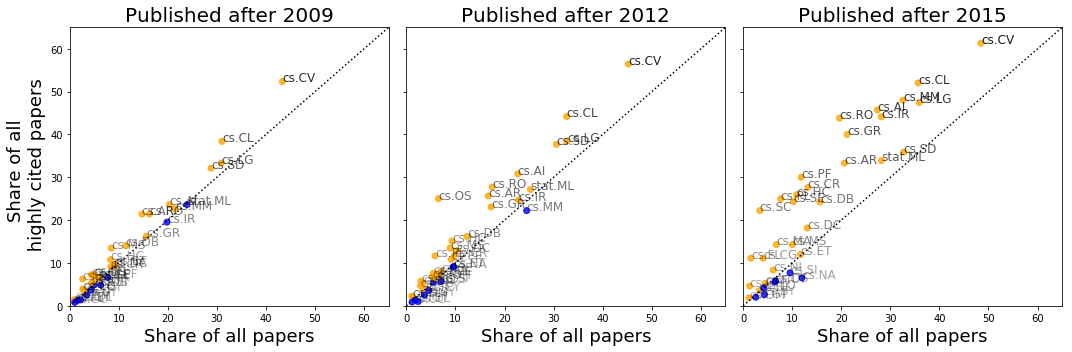

In [48]:
fig,ax = plt.subplots(figsize=(15,5),ncols=3,sharey=True)

make_fig_3(impact_df[0],ax[0])

make_fig_3(impact_df[1],ax[1])

make_fig_3(impact_df[2],ax[2])

ax[1].set_ylabel('')
ax[2].set_ylabel('')

[ax[n].set_title(f'Published after {y}',size=20) for n,y in zip([0,1,2],[2009,2012,2015])]
plt.tight_layout()

plt.savefig('../reports/figures/paper_v2_material/fig_10_impact.pdf')

DL papers are overrepresented in the set of influential papers for most CS disciplines with only a few exceptions (software engineering and performance)

Note that some of the most popular topics for DL (in chart above) are quite low in these rankings because DL papers represent the majority of papers in them already


### Conclusion of the descriptive GPT analysis:

DL seems to fulfil all the properties of a GPT: rapid growth, diffusion in multiple areas and impact (which we proxy through citations). Now we need to analyse what this means for its geography.

## c. Geographical analysis

Having studied the development and diffusion of DL, we want to analyse their geography. What are our hypotheses here?

Our **hypothesis** is that there has been a disruption in the geography of DL: a change in the relative specialisations of countries.

How do we analyse this? 

* First we do a descriptive analysis: line charts and pre/after 2012 comparison of country 'market shares' in DL.
* Second, we do a geographical analysis using dbscan: how does the evolution of DL clustering compare with the evolution of clustering in other domains?

As before, we will write a class to do this.


#### i. Pre-processing: Bin into countries / regions


NB see [here](https://medium.com/@bobhaffner/spatial-joins-in-geopandas-c5e916a763f3) for a quick tutorial on spatial joins

We have lost a few more (2k) observations that had missing country information

#### iii. Geographical change analysis

Now we write a class that will address our spatial questions:

* What is the geographical concentration of DL research compared with other research? 
* How has the geography of DL research changed compared to other fields?
* How have the clusters evolved over time?

In [49]:
#How we we create maps

#Merge paper metadata with paper geographical data
papers_admin = pd.DataFrame(papers_geographies[['admin','name_en','country_reg','geometry']])


papers_nat = pd.DataFrame(papers_countries[['geometry','ADMIN','NAME','SUBREGION','CONTINENT']])
papers_nat.columns = [x.lower() for x in papers_nat]

In [50]:
#Merge with the papers df
papers_admin_map= papers.set_index('paper_id').join(papers_admin,how='left')
papers_nat_map= papers.set_index('paper_id').join(papers_nat,how='left')

papers_admin_map['dl_cat'],papers_nat_map['dl_cat'] = [['dl' if x in papers_expansive else 'not_dl' for x in data] for data in [papers_admin_map.arxiv_id,
                                                                                                  papers_nat_map.arxiv_id]]

In [51]:
country_shape.columns = [x.lower() for x in country_shape.columns]

In [52]:
country_geo_outputs = geo_dash_data(papers_nat_map,country_shape,'name',ranking=5)

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/usr/local/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


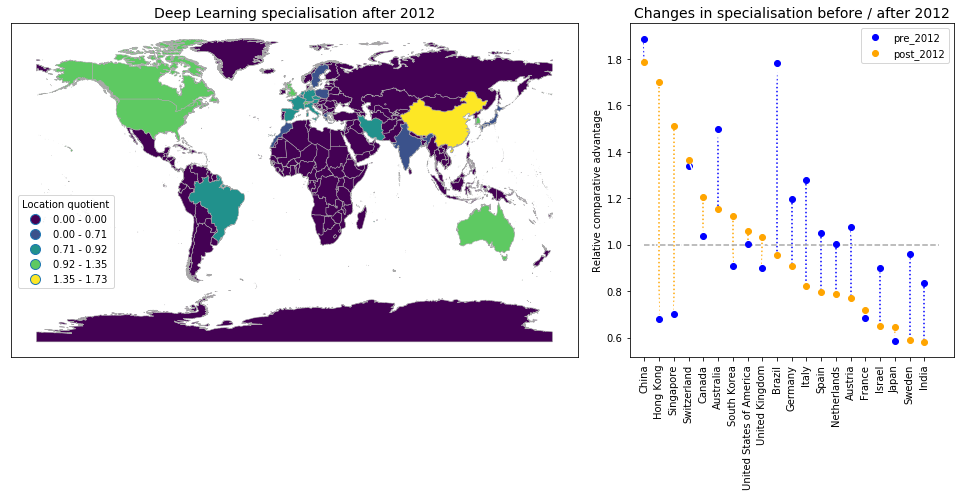

In [53]:
fig,ax = plt.subplots(figsize=(14,7),ncols=2,gridspec_kw={'width_ratios':[1.75,1]})

make_map(country_geo_outputs[0][1],'dl',variable_totals='dl_total',ax=ax[0],cmap='viridis')
make_geo_bar(country_geo_outputs[1].sort_values('post_2012',ascending=False),ax[1])

ax[0].set_title('Deep Learning specialisation after 2012',size=14)
ax[1].set_title('Changes in specialisation before / after 2012',size=14)

plt.tight_layout()

In [54]:
admin_geo_outputs = geo_dash_data(papers_admin_map,admin_shape,'name_en',ranking=30)

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


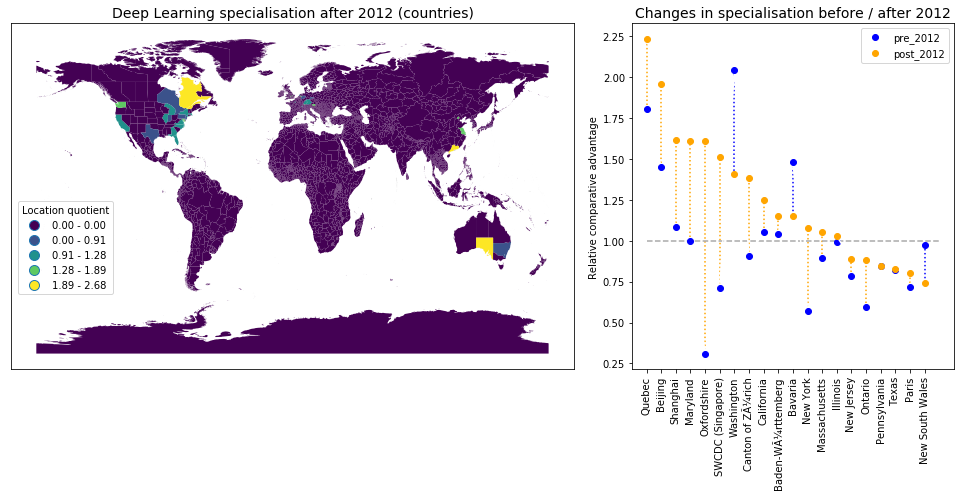

In [55]:
fig,ax = plt.subplots(figsize=(14,7),ncols=2,gridspec_kw={'width_ratios':[1.75,1]})


#make_map(country_geo_outputs[0][0],'dl',variable_totals='dl_total',ax=ax[0],cmap='Blues')
make_map(admin_geo_outputs[0][1],'dl',variable_totals='dl_total',ax=ax[0],cmap='viridis',edge=0,q=0.99)
make_geo_bar(admin_geo_outputs[1].sort_values('post_2012',ascending=False),ax[1])

ax[0].set_title('Deep Learning specialisation after 2012 (countries)',size=14)
ax[1].set_title('Changes in specialisation before / after 2012',size=14)

plt.tight_layout()

#### Volatility and concentration

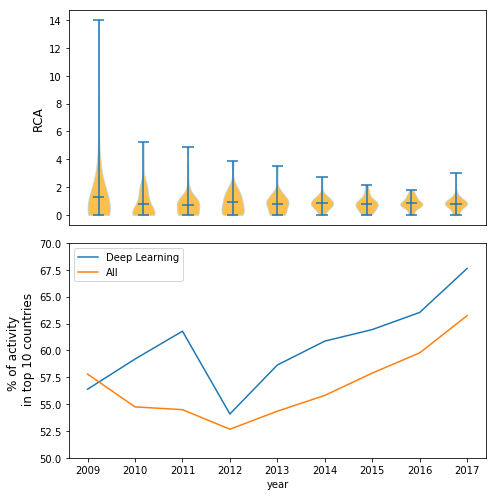

In [56]:
fig,ax = plt.subplots(nrows=2,figsize=(7,7))

selected_countries = papers_nat_map.groupby('name').size().sort_values(ascending=False)[:50].index

volatility_concentration(country_geo_outputs[2],country_geo_outputs[3],ax,selected_countries)

ax[0].set_ylabel('RCA',size=12)
ax[1].set_ylabel('% of activity \n in top 10 countries',size=12)

ax[0].get_xaxis().set_visible(False)
plt.tight_layout()

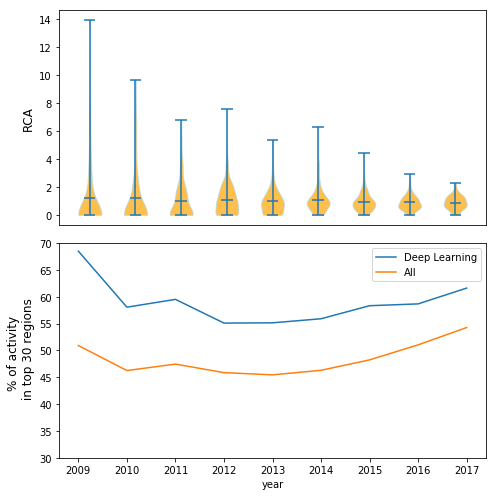

In [57]:
fig,ax = plt.subplots(nrows=2,figsize=(7,7))

selected_regions = papers_admin_map.groupby('name_en').size().sort_values(ascending=False)[:150].index

volatility_concentration(admin_geo_outputs[2],admin_geo_outputs[3],ax,selected_regions,ylim=[30,70])

ax[0].set_ylabel('RCA',size=12)
ax[1].set_ylabel('% of activity \n in top 30 regions',size=12)

ax[0].get_xaxis().set_visible(False)
plt.tight_layout()


### Additional feature engineering

Model

$Dl_{t1} = \beta_1Dl_{t1} + \beta_2arX_{esp} + \beta_3cb_{esp} + \beta_4arx_{tot} + \beta_5cb_{tot} + \beta_6cb_{esp}arx_esp + \beta_7arx_{tot}cb_{tot} + ...$

In order to determine which are the relevant arxiv and CB categories, we need to do some additional feature engineering.

In the case of arxiv, we will look for similar computer science categories based on similarities between words.

In the case of cb, we will look for similar sectoral categories based on a machine learning analysis of keywords that predict labels in CB

#### ArXiv

In [58]:
# Create the DL similarity vector based on topic co-occurrences in papers.

#All this creates a df with the 
#comp_cats = [x for x in set(flatten_list(papers_meta.arxiv_categories)) if any(var == x.split('.')[0] for var in ['cs','stat'])]

arxiv_cats_df = pd.DataFrame()

for comp in comp_cats:
    
    var = [comp in x for x in papers_meta.arxiv_categories]
    
    arxiv_cats_df[comp] = var

arxiv_cats_df.index= papers_meta.index
arxiv_cats_df['dl'] = [ind in papers_expansive for ind in arxiv_cats_df.index]

In [59]:
sim = pd.DataFrame(1-pairwise_distances(arxiv_cats_df.T,metric='cosine'),index=arxiv_cats_df.columns,columns=arxiv_cats_df.columns)

sort_cats = sim.sort_values('dl',ascending=False).index

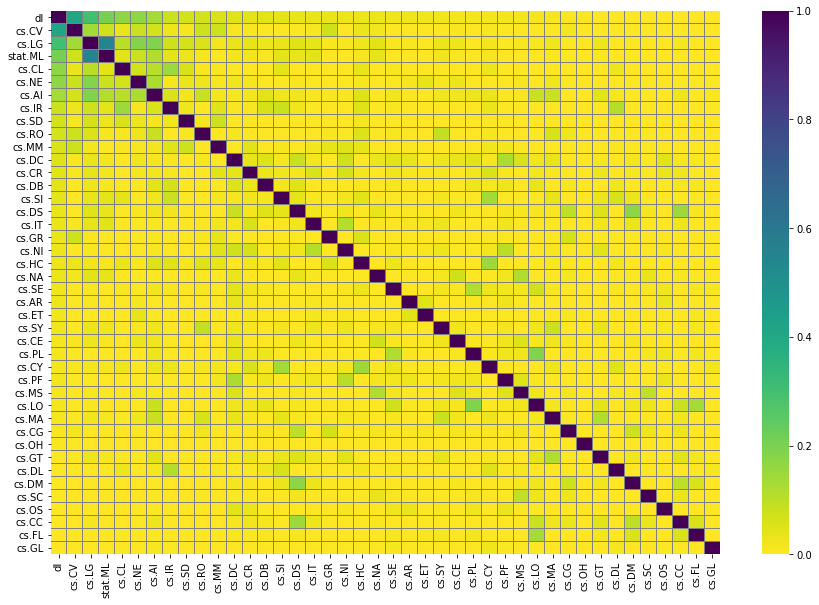

In [60]:
fig,ax = plt.subplots(figsize=(15,10))

import seaborn as sns

sns.heatmap(sim.loc[sort_cats,sort_cats],ax=ax,cmap='viridis_r',linecolor='grey',linewidth=0.01)
#ax.set_title('Similarities between computer science disciplines \n (based on paper co-occcurrence)',size=16)

#### Exploration of correlations

In [61]:
papers_admin_map['expanded_cats'] = [x if y!='dl' else x+['dl'] for x,y in zip(
    papers_admin_map['arxiv_categories'],
    papers_admin_map['dl_cat'])]

#### Modelling

In [62]:
papers_meta_desc['categories_expanded'] = papers_meta_desc['arxiv_categories']


papers_meta_desc['categories_expanded'] = [cats + ['dl'] if dl_cat=='dl' else cats for cats,dl_cat in zip(papers_meta_desc['arxiv_categories'],
                                                                                                               papers_meta_desc['dl_cat'])]

In [63]:
arx_prox_df = pd.read_csv(proc_data+'/arxiv_sector_proximities.csv',index_col=0)

close_cats = arx_prox_df.sum(axis=1).sort_values(ascending=False).index
close_arxiv_cats = arx_prox_df.mean(axis=0).sort_values(ascending=False).index

#arx_prox_df.apply(lambda x: x/x.sum()).sort_values('dl',ascending=False)

In [64]:
paper_freqs = dict(flatten_freqs(papers_meta_desc.categories_expanded))

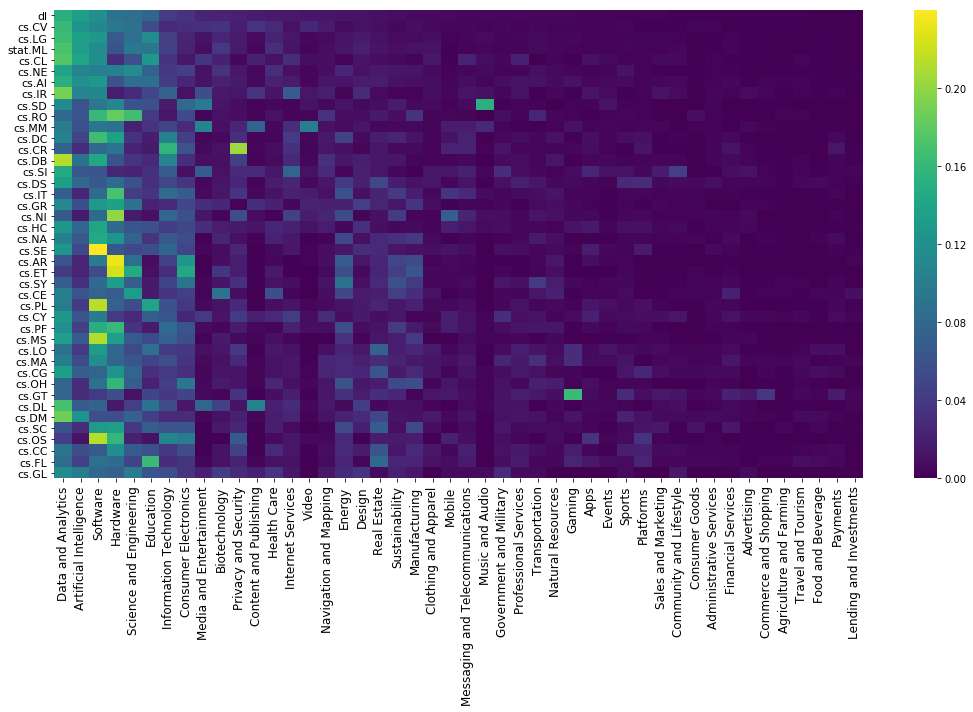

In [65]:
fig,ax = plt.subplots(figsize=(15,10))

sns.heatmap(arx_prox_df.apply(lambda x: x/x.sum()).sort_values('dl',ascending=False).T.loc[sort_cats],ax=ax,cmap='viridis')

ax.set_yticklabels(ax.get_yticklabels(),fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)

#plt.colorbar(im, use_gridspec=True)

plt.tight_layout()

### Multivariate analysis

In [66]:
#Initial prep:

#Country lookup
country_reg_lookup = {x:y for x,y in zip(admin_shape['name_en'],admin_shape['iso_a2'])}

In [67]:
#Focus on top arxiv areas?

top_q_regions = papers_admin_map.groupby(['name_en']).size().quantile(0.75)


top_locs = papers_admin_map.groupby(['name_en']).size().index[papers_admin_map.groupby(['name_en']).size()>top_q_regions]

In [68]:
papers_modelling = papers_admin_map.copy()

In [69]:
papers_admin_map['expanded_cats'] = [x if y!='dl' else x + ['dl'] for x,y in zip(papers_admin_map['arxiv_categories'],
                                                                                papers_admin_map['dl_cat'])]

In [70]:
papers_modelling['cats'] = [[cat for cat in x if cat!='dl'] for x in papers_modelling['arxiv_categories']]

In [71]:
papers_modelling['cats'] = [x+['dl'] if y=='dl' else x for x,y in zip(papers_modelling['cats'],papers_modelling['dl_cat'])]

In [75]:
sel = list(set(flatten_list(cb['category_split_list'])))

In [76]:
d_t = data_temp('dl','cats')

In [77]:
indeps = [['arx_sp','arx_tot','is_china'],
          ['arx_sp',
           'cb_sp',
           'arx_tot','is_china'],
          ['arx_sp',
           'cb_sp',
           'sp_int','arx_tot','is_china'],
          ['arx_sp',
           'cb_sp',
           'sp_int','abs_int','arx_tot','is_china']]


dl_models = [model_temp(d_t,'dl',top_locs=0.5,exog_vars=x)[0] for x in indeps]

reg_table = pd.concat([create_reg_table(x) for x in dl_models],axis=1).fillna('')

reg_table = reg_table.loc[['y',
    'dl_t0','dl_t0_se','arx_sp','arx_sp_se',
                           'cb_sp','cb_sp_se',
                           'sp_int','sp_int_se',
                           'abs_int','abs_int_se',
                           'arx_tot','arx_tot_se',
                           'is_china','is_china_se',
                           'R^2',
                           'n']]

reg_table.index = [x if '_se' not in x else '' for x in reg_table.index]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [78]:
var_names = {'y':'y','dl_t1':'RCA_t1',
    'dl_t0':'RCA_t0',
            'arx_sp':'arXiv_sp',
            'cb_sp':'CrunchBase_sp',
            'sp_int':'arXiv_sp*CrunchBase_sp',
            'abs_int':'arXiv_sp*CrunchBase_tot',
            'arx_tot':'arXiv_tot',
            'is_china':'is_china',
            'R^2':'R2',
            'n':'n'}

In [79]:
reg_table.index = [var_names[x] if x!='' else x for x in reg_table.index]
             
             
reg_table.columns = ['Model '+str(x+1) for x in reg_table.columns]

In [80]:
reg_table

,Model 1,Model 2,Model 3,Model 4
y,RCA_t1,RCA_t1,RCA_t1,RCA_t1
RCA_t0,0.12***,0.121***,0.124***,0.126***
,(0.044),(0.044),(0.044),(0.043)
arXiv_sp,0.159***,0.161***,-0.015,0.002
,(0.044),(0.044),(0.082),(0.082)
CrunchBase_sp,,0.023,-0.171*,-0.145
,,(0.044),(0.089),(0.089)
arXiv_sp*CrunchBase_sp,,,0.274**,0.243**
,,,(0.109),(0.109)
arXiv_sp*CrunchBase_tot,,,,0.203**


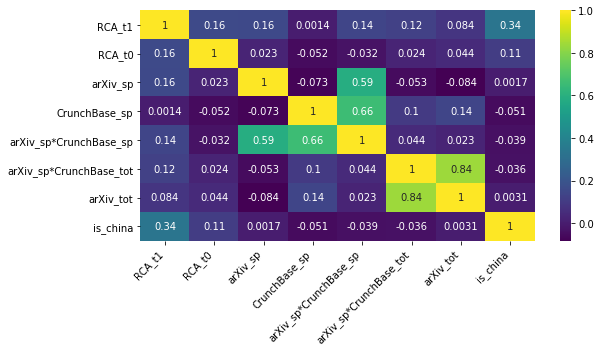

In [81]:
fig,ax = plt.subplots(figsize=(9,5))


sns.heatmap(model_temp(d_t,'dl',top_locs=0.5,exog_vars=indeps[-1])[1][['dl_t1','dl_t0']+indeps[-1]].corr(),cmap='viridis',ax=ax,annot=True)

ax.set_yticklabels([var_names[x.get_text()] for x in ax.get_yticklabels()])
ax.set_xticklabels([var_names[x.get_text()] for x in ax.get_xticklabels()],rotation=45,ha='right')

plt.tight_layout()

In [82]:
kwargs = {'top':0.5,
          'exog_vars':['const',
                       'arx_sp',
                       'cb_sp',
                       'sp_int',
                       'arx_tot',
                       'abs_int',
                       'is_china'],
          'my_vars':[
                     'arx_sp',
                     'sp_int','abs_int','is_china']}

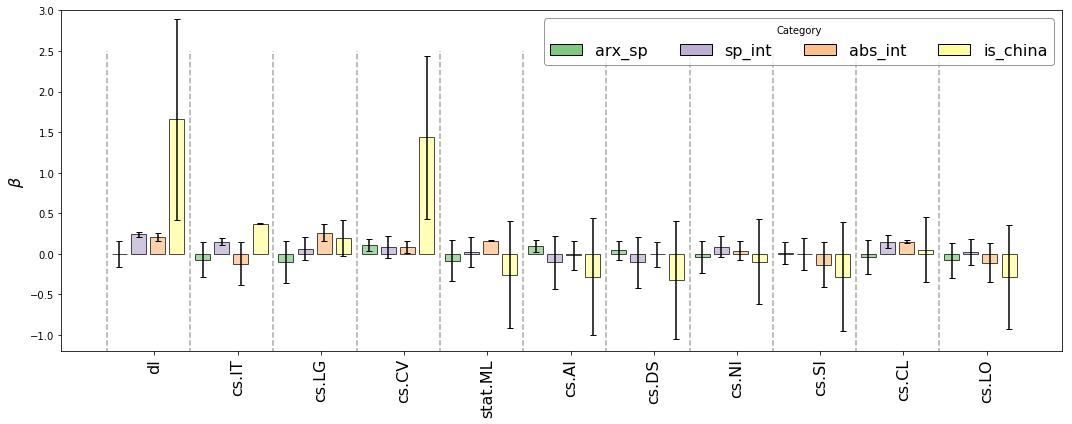

In [83]:
fig,ax = plt.subplots(figsize=(15,6))

reg_comp_plot(ax,top_cats=10,**kwargs)

ax.set_ylabel(r'$\beta$',size=16)

ax.set_ylim((-1.2,3))

plt.tight_layout()

plt.savefig('../reports/figures/paper_v2_material/fig_16_comparison.pdf')